In [1]:
import sys
print(sys.executable)

/usr/local/bin/python3


In [2]:
#imports

import numpy as np


In [ ]:
# Task 1, Preparing the dataset
# WOS-11967 is a list of 11967 abstracts from scientific papers alongside 2 labels for each instance - (main domain, sub domain)

"""
1. Load the raw text and labels. (each abstract is on each line)
2. Tokenize the abstracts.
3. Build a vocabulary for word-level LSTM. (LSTM needs words, not tokens like BERT)
4. Encode each abstract as a padded sequence of word IDs.
5. Track the true sequence lengths (before padding).
6. Split into train/val/test sets (categorized by main label).
7. Save processed tensors to disk for later use.

outputs:
- wos_lstm_train.pt
- wos_lstm_val.pt
- wos_lstm_test.pt
- wos_bert_train.pt
- wos_bert_val.pt
- wos_bert_test.pt
"""

# NOTE: THE CODE WAS RUN ON GOOGLE COLAB SEPARATELY.

import os
import re
import argparse
from collections import Counter

import numpy as np
import torch
from sklearn.model_selection import train_test_split

# load raw dataset files
"""
returns
- texts: list[abstract]
- labels_main: np.array(11967)
- labels_sub: np.array(11967)
"""

def load_wos_txt():
    x_path = "./dataset/X.txt"
    yl1_path = "./dataset/YL1.txt"
    yl2_path = "./dataset/YL2.txt"

    with open(x_path, encoding="utf-8") as f:
        texts = [line.strip() for line in f]

    with open(yl1_path, encoding="utf-8") as f:
        labels_main = [int(line.strip()) for line in f]

    with open(yl2_path, encoding="utf-8") as f:
        labels_sub = [int(line.strip()) for line in f]

    return texts, np.array(labels_main, dtype=np.int64), np.array(labels_sub, dtype=np.int64)


# tokenization, regex is to replace any non "regular" characters with spaces
_token_pattern = re.compile(r"[^a-z0-9]+")

def simple_tokenize(text):
    text = text.lower()
    text = _token_pattern.sub(" ", text)
    return text.split()

def tokenize_inputs(texts):
    return [simple_tokenize(t) for t in texts]

# super simple "embedding" method; go over all the words, and as long as they appear more than twice (prevent URLs and stuff like that),
# add to the vocab with id = len(vocab) (which means each new vocab word added, the length of vocab increases)
# keep <PAD> and <UNK> for padding (PAD in case abstract too short, UNK for "unknown" token in case an unknown word appears) 
def build_vocab(tokenized_texts, min_freq):
    counter = Counter()
    for toks in tokenized_texts:
        counter.update(toks)

    vocab = {"<PAD>": 0, "<UNK>": 1}
    for tok, freq in counter.items():
        if freq >= min_freq:
            vocab[tok] = len(vocab)
    return vocab

"""
output is
- input_ids: N x max_len matrix of our embeddings. Contains our custom embedding logic + PAD whenever the abstract length < max_len.
    obviously, if abstract length > max_len, it gets right truncated
- lengths: N length array of (actual) lengths of the abstracts. Of course, if ith abstract length > max_len, lengths[i] = max_len 
"""
def encode_and_pad(tokenized_texts, vocab, max_len=None):
    lengths_raw = np.array([len(toks) for toks in tokenized_texts], dtype=np.int64)

    if max_len is None:
        # the LSTM input is only as long as the 95% longest
        max_len = int(np.percentile(lengths_raw, 95))

    N = len(tokenized_texts)
    # here is the init of the "embeddings" matrix (initially full of <PAD> (0))
    input_ids = np.full((N, max_len), fill_value=vocab["<PAD>"], dtype=np.int64)
    lengths = np.zeros(N, dtype=np.int64)

    for i, toks in enumerate(tokenized_texts):
        # THE embedding step
        ids = [vocab.get(tok, vocab["<UNK>"]) for tok in toks]
        truncated = ids[:max_len]
        input_ids[i, :len(truncated)] = truncated
        lengths[i] = min(len(ids), max_len)

    return input_ids, lengths, max_len



# very simply use the bert tokenizer for bert. Assume same 95th percentile max length.
# input_ids, same concept as above, but when fed into BERT, BERT internally maps the inputs
def build_bert_features(texts, top95length):
    from transformers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        max_length=top95length,
        return_tensors="pt"
    )
    return encodings["input_ids"], encodings["attention_mask"]



# splits
def split_indices(labels_main, test_size=0.25, val_size=0.25, seed=67):
    """
    Returns train_idx, val_idx, test_idx (NumPy arrays of indices),
    stratified by main labels.
    """
    N = len(labels_main)
    indices = np.arange(N)

    train_idx, temp_idx = train_test_split(
        indices,
        test_size=test_size,
        stratify=labels_main,
        random_state=seed,
    )

    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=val_size,
        stratify=labels_main[temp_idx],
        random_state=seed,
    )

    return train_idx, val_idx, test_idx



def main():
    # 1. Load raw data
    texts, labels_main, labels_sub = load_wos_txt()
    print(f"Loaded {len(texts)} abstracts.")

    # 2. LSTM pipeline: tokenize -> vocab -> encode and pad
    tokenized = tokenize_inputs(texts)
    print("Example tokens:", tokenized[0][:5])

    vocab = build_vocab(tokenized, min_freq=3)
    print(f"LSTM vocab size (including PAD/UNK): {len(vocab)}")

    lstm_input_ids, lstm_lengths, max_len_lstm_used = encode_and_pad(
        tokenized,
        vocab
    )
    print(f"LSTM encoded shape: {lstm_input_ids.shape} (max_len={max_len_lstm_used})")

    # 3. BERT pipeline: tokenizer -> input_ids + attention mask
    bert_input_ids, bert_attention_mask = build_bert_features(
        texts,
        top95length=max_len_lstm_used
    )
    print(f"BERT encoded shape: {bert_input_ids.shape} (max_len={max_len_lstm_used})")

    # 4. Shared train/val/test indices
    train_idx, val_idx, test_idx = split_indices(
        labels_main
    )

    # 5. Build LSTM splits
    train_lstm = {
        "input_ids": torch.from_numpy(lstm_input_ids[train_idx]),
        "lengths": torch.from_numpy(lstm_lengths[train_idx]),
        "label_main": torch.from_numpy(labels_main[train_idx]),
        "label_sub": torch.from_numpy(labels_sub[train_idx]),
    }
    val_lstm = {
        "input_ids": torch.from_numpy(lstm_input_ids[val_idx]),
        "lengths": torch.from_numpy(lstm_lengths[val_idx]),
        "label_main": torch.from_numpy(labels_main[val_idx]),
        "label_sub": torch.from_numpy(labels_sub[val_idx]),
    }
    test_lstm = {
        "input_ids": torch.from_numpy(lstm_input_ids[test_idx]),
        "lengths": torch.from_numpy(lstm_lengths[test_idx]),
        "label_main": torch.from_numpy(labels_main[test_idx]),
        "label_sub": torch.from_numpy(labels_sub[test_idx]),
    }

    # 6. Build BERT splits
    train_bert = {
        "input_ids": bert_input_ids[train_idx],
        "attention_mask": bert_attention_mask[train_idx],
        "label_main": torch.from_numpy(labels_main[train_idx]),
        "label_sub": torch.from_numpy(labels_sub[train_idx]),
    }
    val_bert = {
        "input_ids": bert_input_ids[val_idx],
        "attention_mask": bert_attention_mask[val_idx],
        "label_main": torch.from_numpy(labels_main[val_idx]),
        "label_sub": torch.from_numpy(labels_sub[val_idx]),
    }
    test_bert = {
        "input_ids": bert_input_ids[test_idx],
        "attention_mask": bert_attention_mask[test_idx],
        "label_main": torch.from_numpy(labels_main[test_idx]),
        "label_sub": torch.from_numpy(labels_sub[test_idx]),
    }

    # 7. Save everything
    torch.save(train_lstm, "wos_lstm_train.pt")
    torch.save(val_lstm, "wos_lstm_val.pt")
    torch.save(test_lstm, "wos_lstm_test.pt")
    print("Saved LSTM splits: wos_lstm_train.pt, wos_lstm_val.pt, wos_lstm_test.pt")

    torch.save(train_bert, "wos_bert_train.pt")
    torch.save(val_bert, "wos_bert_val.pt")
    torch.save(test_bert, "wos_bert_test.pt")
    print("Saved BERT splits: wos_bert_train.pt, wos_bert_val.pt, wos_bert_test.pt")

    torch.save(
        {
            "vocab": vocab,
            "min_freq": 3,
            "max_len_lstm": max_len_lstm_used,
        },
        "wos_vocab.pt"
    )
    print("Saved vocab: wos_vocab.pt")


main()

ValueError: mount failed

In [11]:
#useful functions
def l2_loss(y, yh):
  return 0.5 * (yh - y)**2

def l2_loss_grad(y, yh):
  return yh - y

def cross_entropy(y, yh):
  return -np.sum(y * np.log(yh + 1e-12))

# note that this is true only for dL/dz, L = loss(softmax(z))
def cross_entropy_grad(y, yh):
  return yh - y

def relu(x):
  return np.maximum(0, x)
   
def relu_grad(x):
    return (x > 0).astype(float)

def leaky_relu(x, alpha=0.1):
   return np.maximum(alpha*x, x)

def leaky_relu_grad(x, alpha=0.1):
    grad = np.ones_like(x)
    grad[x < 0] = alpha
    return grad

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_grad(x):
    s = sigmoid(x)
    return s * (1 - s)
  
def tanh(x):
  return np.tanh(x)

def tanh_grad(x):
  t = np.tanh(x)
  return 1 - t * t

def linear(x):
  return x

def linear_grad(x):
  return np.ones_like(x)

def softmax(x):
  z = x - np.max(x)
  e = np.exp(z)
  return e / np.sum(e)

In [ ]:
#task 2 implement LSTM

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class Cell(nn.Module):
    def __init__(self, input_size, hidden_size, b_f=None, b_i=None, b_o=None, b_c=None):
        """
        Manual LSTM cell implemented with PyTorch tensors.

        input_size: dimension of x_t (e.g., embedding dim)
        hidden_size: dimension of h_t, c_t
        """
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # weight matrices for gates: shape (hidden_size, input_size + hidden_size)
        self.W_f = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)
        self.W_i = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)
        self.W_c = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)
        self.W_o = nn.Parameter(torch.randn(hidden_size, input_size + hidden_size) * 0.01)

        # initialize biases (follow your original logic)
        if b_f is None:
            b_f = torch.ones(hidden_size)
        if b_i is None:
            b_i = torch.zeros(hidden_size)
        if b_o is None:
            b_o = torch.zeros(hidden_size)
        if b_c is None:
            b_c = torch.zeros(hidden_size)

        self.b_f = nn.Parameter(b_f)
        self.b_i = nn.Parameter(b_i)
        self.b_o = nn.Parameter(b_o)
        self.b_c = nn.Parameter(b_c)

    def forward(self, h_prev, c_prev, x_t):
        """
        One LSTM step.

        h_prev: (batch_size, hidden_size)
        c_prev: (batch_size, hidden_size)
        x_t:    (batch_size, input_size)
        returns: h_t, c_t
        """
        # concat: (batch_size, hidden_size + input_size)
        concat = torch.cat([h_prev, x_t], dim=1)

        # gates
        f_t = torch.sigmoid(concat @ self.W_f.T + self.b_f)  # forget gate
        i_t = torch.sigmoid(concat @ self.W_i.T + self.b_i)  # input gate
        c_hat = torch.tanh(concat @ self.W_c.T + self.b_c)   # cell candidate
        c_t = f_t * c_prev + i_t * c_hat                     # new cell state
        o_t = torch.sigmoid(concat @ self.W_o.T + self.b_o)  # output gate
        h_t = o_t * torch.tanh(c_t)                          # new hidden state

        return h_t, c_t


class LSTM(nn.Module):  # note: seq2vec
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_size,
        num_classes=7,
        pad_index=0
    ):
        """
        Manual LSTM classifier with an embedding layer + custom LSTM cell.

        vocab_size: size of vocabulary for word IDs
        embedding_dim: dimension of word embeddings
        hidden_size: LSTM hidden size
        num_classes: number of output classes (7 for main labels, 33 for sub)
        pad_index: ID used for <PAD> in wos_vocab.pt (0 in your preprocessing)
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.pad_index = pad_index

        # Embedding layer for token IDs -> vectors
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=pad_index
        )

        # One LSTM cell that we will iterate over time
        self.cell = Cell(input_size=embedding_dim, hidden_size=hidden_size)

        # Classification head: final h_T -> logits
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, lengths):
        """
        Forward pass over a batch of sequences.

        input_ids: LongTensor of shape (batch_size, seq_len)
        lengths:   LongTensor of shape (batch_size,) with true lengths (no padding)
        returns: logits of shape (batch_size, num_classes)
        """
        device = input_ids.device
        lengths = lengths.to(device)

        # (batch_size, seq_len, embedding_dim)
        embeddings = self.embedding(input_ids)

        batch_size, seq_len, _ = embeddings.size()

        # initial hidden + cell state
        h = torch.zeros(batch_size, self.hidden_size, device=device)
        c = torch.zeros(batch_size, self.hidden_size, device=device)

        # iterate over time; mask paddings using lengths
        for t in range(seq_len):
            x_t = embeddings[:, t, :]  # (batch_size, embedding_dim)

            # mask: 1 for real tokens, 0 for padding
            # shape (batch_size, 1)
            mask = (t < lengths).float().unsqueeze(1)

            h_t, c_t = self.cell(h, c, x_t)

            # keep previous state for padded positions
            h = mask * h_t + (1.0 - mask) * h
            c = mask * c_t + (1.0 - mask) * c

        # use final hidden state as sequence representation
        logits = self.fc(h)
        return logits

    def fit(
        self,
        train_input_ids,
        train_lengths,
        train_labels,
        val_input_ids=None,
        val_lengths=None,
        val_labels=None,
        batch_size=32,
        epochs=5,
        lr=1e-3,
        device=None,
    ):
        """
        Train the LSTM on tensors from wos_lstm_*.pt.

        train_input_ids: LongTensor (N_train, seq_len)
        train_lengths:   LongTensor (N_train,)
        train_labels:    LongTensor (N_train,) in [0, num_classes)
        val_*:           optional validation tensors with same shapes
        """
        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(device)

        train_dataset = TensorDataset(train_input_ids, train_lengths, train_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        if val_input_ids is not None and val_lengths is not None and val_labels is not None:
            val_dataset = TensorDataset(val_input_ids, val_lengths, val_labels)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        else:
            val_loader = None

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            self.train()
            total_loss = 0.0
            total_examples = 0

            for batch_ids, batch_lengths, batch_labels in train_loader:
                batch_ids = batch_ids.to(device)
                batch_lengths = batch_lengths.to(device)
                batch_labels = batch_labels.to(device)

                optimizer.zero_grad()
                logits = self.forward(batch_ids, batch_lengths)
                loss = criterion(logits, batch_labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * batch_labels.size(0)
                total_examples += batch_labels.size(0)

            avg_loss = total_loss / max(total_examples, 1)

            if val_loader is not None:
                val_acc = self.evaluate_acc(
                    val_input_ids,
                    val_lengths,
                    val_labels,
                    batch_size=batch_size,
                    device=device,
                )
                print(f"Epoch {epoch + 1}/{epochs} | Train loss: {avg_loss:.4f} | Val acc: {val_acc:.4f}")
            else:
                print(f"Epoch {epoch + 1}/{epochs} | Train loss: {avg_loss:.4f}")

    def predict(self, input_ids, lengths, batch_size=32, device=None):
        """
        Predict class labels for a set of sequences.

        input_ids: LongTensor (N, seq_len)
        lengths:   LongTensor (N,)
        returns:   LongTensor (N,) of predicted labels
        """
        if device is None:
            device = next(self.parameters()).device

        self.eval()
        dataset = TensorDataset(input_ids, lengths)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        preds_list = []
        with torch.no_grad():
            for batch_ids, batch_lengths in loader:
                batch_ids = batch_ids.to(device)
                batch_lengths = batch_lengths.to(device)
                logits = self.forward(batch_ids, batch_lengths)
                preds = torch.argmax(logits, dim=1)
                preds_list.append(preds.cpu())

        return torch.cat(preds_list, dim=0)

    def evaluate_acc(self, input_ids, lengths, labels, batch_size=32, device=None):
        """
        Compute accuracy on a dataset.

        input_ids: LongTensor (N, seq_len)
        lengths:   LongTensor (N,)
        labels:    LongTensor (N,)
        returns:   scalar accuracy in [0,1]
        """
        if device is None:
            device = next(self.parameters()).device

        self.eval()
        dataset = TensorDataset(input_ids, lengths, labels)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

        correct = 0
        total = 0
        with torch.no_grad():
            for batch_ids, batch_lengths, batch_labels in loader:
                batch_ids = batch_ids.to(device)
                batch_lengths = batch_lengths.to(device)
                batch_labels = batch_labels.to(device)

                logits = self.forward(batch_ids, batch_lengths)
                preds = torch.argmax(logits, dim=1)

                correct += (preds == batch_labels).sum().item()
                total += batch_labels.size(0)

        return correct / total if total > 0 else 0.0


In [18]:
# TASK 2a: Train PyTorch LSTM on WOS-11967 (main and sub labels)

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device for LSTM:", device)

def _load_split(base_name):
    """
    Helper to load a split whether it is saved under 'dataset/' or at root.
    """
    try:
        return torch.load("dataset/" + base_name)
    except FileNotFoundError:
        return torch.load(base_name)

# 1) Load LSTM splits and vocab created in Task 1
train_lstm = _load_split("wos_lstm_train.pt")
val_lstm   = _load_split("wos_lstm_val.pt")
test_lstm  = _load_split("wos_lstm_test.pt")

try:
    vocab_obj = torch.load("dataset/wos_vocab.pt")
except FileNotFoundError:
    vocab_obj = torch.load("wos_vocab.pt")

vocab = vocab_obj["vocab"]
vocab_size = len(vocab)
pad_index = vocab.get("<PAD>", 0)

print(f"Vocab size: {vocab_size}, PAD index: {pad_index}")

# tensors for both tasks
train_input_ids   = train_lstm["input_ids"].long()
train_lengths     = train_lstm["lengths"].long()
train_labels_main = train_lstm["label_main"].long()
train_labels_sub  = train_lstm["label_sub"].long()

val_input_ids   = val_lstm["input_ids"].long()
val_lengths     = val_lstm["lengths"].long()
val_labels_main = val_lstm["label_main"].long()
val_labels_sub  = val_lstm["label_sub"].long()

test_input_ids   = test_lstm["input_ids"].long()
test_lengths     = test_lstm["lengths"].long()
test_labels_main = test_lstm["label_main"].long()
test_labels_sub  = test_lstm["label_sub"].long()

print("Train set shape:", train_input_ids.shape)
print("Val set shape:  ", val_input_ids.shape)
print("Test set shape: ", test_input_ids.shape)

# 2) Hyperparameters for the LSTM
embedding_dim = 50
hidden_size   = 64
batch_size    = 32
epochs        = 10
lr            = 1e-3

# 3) Train LSTM for main (7-class) labels
lstm_main_model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_classes=7,
    pad_index=pad_index,
)

print("\nTraining LSTM for main labels (7 classes)...")
lstm_main_model.fit(
    train_input_ids,
    train_lengths,
    train_labels_main,
    val_input_ids=val_input_ids,
    val_lengths=val_lengths,
    val_labels=val_labels_main,
    batch_size=batch_size,
    epochs=epochs,
    lr=lr,
    device=device,
)

lstm_test_acc_main = lstm_main_model.evaluate_acc(
    test_input_ids,
    test_lengths,
    test_labels_main,
    batch_size=batch_size,
    device=device,
)
print(f"LSTM test accuracy, main label (7 classes): {lstm_test_acc_main:.4f}")

# 4) Train LSTM for sub (33-class) labels
lstm_sub_model = LSTM(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_classes=33,
    pad_index=pad_index,
)

print("\nTraining LSTM for sub labels (33 classes)...")
lstm_sub_model.fit(
    train_input_ids,
    train_lengths,
    train_labels_sub,
    val_input_ids=val_input_ids,
    val_lengths=val_lengths,
    val_labels=val_labels_sub,
    batch_size=batch_size,
    epochs=epochs,
    lr=lr,
    device=device,
)

lstm_test_acc_sub = lstm_sub_model.evaluate_acc(
    test_input_ids,
    test_lengths,
    test_labels_sub,
    batch_size=batch_size,
    device=device,
)
print(f"LSTM test accuracy, sub label (33 classes): {lstm_test_acc_sub:.4f}")


Using device for LSTM: cuda
Vocab size: 28243, PAD index: 0
Train set shape: torch.Size([8975, 333])
Val set shape:   torch.Size([2244, 333])
Test set shape:  torch.Size([748, 333])

Training LSTM for main labels (7 classes)...
Epoch 1/10 | Train loss: 1.8089 | Val acc: 0.3289
Epoch 2/10 | Train loss: 1.5053 | Val acc: 0.4153
Epoch 3/10 | Train loss: 1.2552 | Val acc: 0.5339
Epoch 4/10 | Train loss: 1.0526 | Val acc: 0.5593
Epoch 5/10 | Train loss: 0.9008 | Val acc: 0.6359
Epoch 6/10 | Train loss: 0.9077 | Val acc: 0.6684
Epoch 7/10 | Train loss: 0.6676 | Val acc: 0.7143
Epoch 8/10 | Train loss: 0.5280 | Val acc: 0.7509
Epoch 9/10 | Train loss: 0.4631 | Val acc: 0.7620
Epoch 10/10 | Train loss: 0.3754 | Val acc: 0.7714
LSTM test accuracy, main label (7 classes): 0.7647

Training LSTM for sub labels (33 classes)...
Epoch 1/10 | Train loss: 1.7602 | Val acc: 0.2108
Epoch 2/10 | Train loss: 1.6065 | Val acc: 0.2179
Epoch 3/10 | Train loss: 1.5919 | Val acc: 0.2264
Epoch 4/10 | Train loss:

In [21]:
# TASK 2 part b: BERT models (main and sub labels)

from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# load WOS BERT features produced in Task 1
train_bert = torch.load("dataset/wos_bert_train.pt")
val_bert   = torch.load("dataset/wos_bert_val.pt")
test_bert  = torch.load("dataset/wos_bert_test.pt")

train_input_ids = train_bert["input_ids"]
train_attention = train_bert["attention_mask"]
train_labels_main = train_bert["label_main"]
train_labels_sub  = train_bert["label_sub"]

val_input_ids = val_bert["input_ids"]
val_attention = val_bert["attention_mask"]
val_labels_main = val_bert["label_main"]
val_labels_sub  = val_bert["label_sub"]

test_input_ids = test_bert["input_ids"]
test_attention = test_bert["attention_mask"]
test_labels_main = test_bert["label_main"]
test_labels_sub  = test_bert["label_sub"]

batch_size = 16
epochs_main = 3
epochs_sub = 3
lr = 2e-5

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def make_loaders(labels_tensor):
    train_dataset = TensorDataset(train_input_ids, train_attention, labels_tensor["train"])
    val_dataset   = TensorDataset(val_input_ids,   val_attention,   labels_tensor["val"])
    test_dataset  = TensorDataset(test_input_ids,  test_attention,  labels_tensor["test"])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
            outputs = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            correct += (preds == b_labels).sum().item()
            total += b_labels.size(0)
    return correct / total if total > 0 else 0.0


# main-label model (7):

labels_main_dict = {
    "train": train_labels_main,
    "val":   val_labels_main,
    "test":  test_labels_main,
}
train_loader_main, val_loader_main, test_loader_main = make_loaders(labels_main_dict)

num_labels_main = 7
bert_main_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels_main
)
bert_main_model.to(device)
optimizer_main = AdamW(bert_main_model.parameters(), lr=lr)

print("Fine-tuning BERT for main labels (7 classes)...")
for epoch in range(epochs_main):
    bert_main_model.train()
    total_loss = 0.0
    for batch in train_loader_main:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

        optimizer_main.zero_grad()
        outputs = bert_main_model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer_main.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_main)
    val_acc = evaluate_accuracy(bert_main_model, val_loader_main)
    print(f"[Main] Epoch {epoch + 1}/{epochs_main} | Train loss: {avg_loss:.4f} | Val acc: {val_acc:.4f}")

bert_test_acc_main = evaluate_accuracy(bert_main_model, test_loader_main)
print(f"BERT main-label test accuracy: {bert_test_acc_main:.4f}")


# sub-label model (33):

labels_sub_dict = {
    "train": train_labels_sub,
    "val":   val_labels_sub,
    "test":  test_labels_sub,
}
train_loader_sub, val_loader_sub, test_loader_sub = make_loaders(labels_sub_dict)

num_labels_sub = 33
bert_sub_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels_sub
)
bert_sub_model.to(device)
optimizer_sub = AdamW(bert_sub_model.parameters(), lr=lr)

print("\nFine-tuning BERT for sub labels (33 classes)...")
for epoch in range(epochs_sub):
    bert_sub_model.train()
    total_loss = 0.0
    for batch in train_loader_sub:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

        optimizer_sub.zero_grad()
        outputs = bert_sub_model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels
        )
        loss = outputs.loss
        loss.backward()
        optimizer_sub.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_sub)
    val_acc = evaluate_accuracy(bert_sub_model, val_loader_sub)
    print(f"[Sub] Epoch {epoch + 1}/{epochs_sub} | Train loss: {avg_loss:.4f} | Val acc: {val_acc:.4f}")

bert_test_acc_sub = evaluate_accuracy(bert_sub_model, test_loader_sub)
print(f"BERT sub-label test accuracy: {bert_test_acc_sub:.4f}")


Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning BERT for main labels (7 classes)...
[Main] Epoch 1/3 | Train loss: 0.5573 | Val acc: 0.9153
[Main] Epoch 2/3 | Train loss: 0.1757 | Val acc: 0.9269
[Main] Epoch 3/3 | Train loss: 0.1081 | Val acc: 0.9314
BERT main-label test accuracy: 0.9398


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fine-tuning BERT for sub labels (33 classes)...
[Sub] Epoch 1/3 | Train loss: 1.2123 | Val acc: 0.8534
[Sub] Epoch 2/3 | Train loss: 0.3724 | Val acc: 0.8788
[Sub] Epoch 3/3 | Train loss: 0.2173 | Val acc: 0.8601
BERT sub-label test accuracy: 0.8810


Comparison of LSTM and BERT on WOS-11967 (★ = best test accuracy for that task):


,Model,Task,Test accuracy,Winner
0,LSTM,Main (7 classes),0.764706,
1,LSTM,Sub (33 classes),0.633690,
2,BERT,Main (7 classes),0.939840,★
3,BERT,Sub (33 classes),0.881016,★


Using 2 correctly classified and 2 misclassified examples for attention analysis.


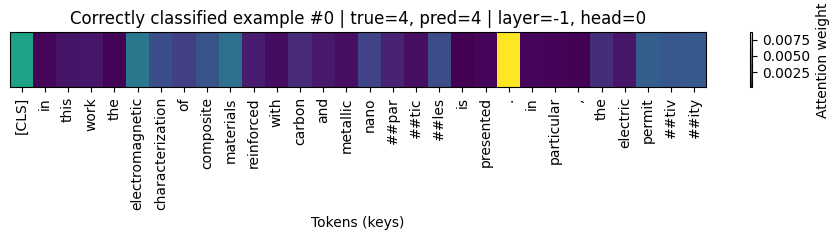

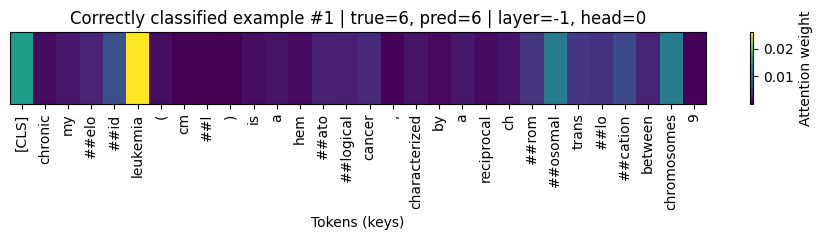

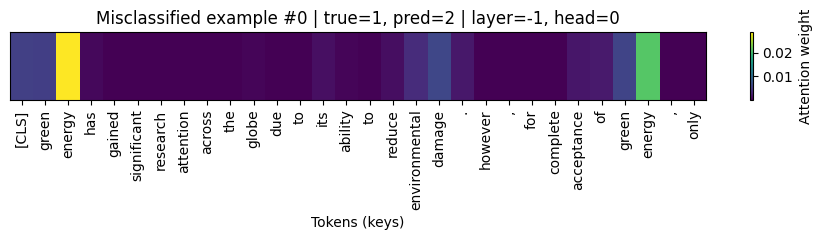

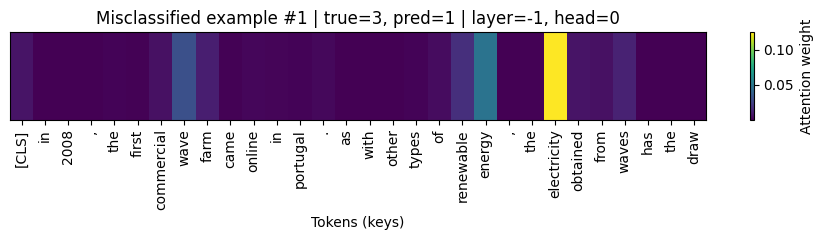

In [25]:
# TASK 3: experiments and attention analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import display

# 1) comparison table for both classification tasks

results = [
    ("LSTM", "Main (7 classes)",  lstm_test_acc_main),
    ("LSTM", "Sub (33 classes)",  lstm_test_acc_sub),
    ("BERT", "Main (7 classes)",  bert_test_acc_main),
    ("BERT", "Sub (33 classes)",  bert_test_acc_sub),
]

results_df = pd.DataFrame(results, columns=["Model", "Task", "Test accuracy"])

# mark the winner per task (higher accuracy) so the table itself highlights it
results_df["Winner"] = ""
for task in results_df["Task"].unique():
    task_mask = results_df["Task"] == task
    best_idx = results_df.loc[task_mask, "Test accuracy"].idxmax()
    results_df.loc[best_idx, "Winner"] = "★"   # star marks best model for that task

print("Comparison of LSTM and BERT on WOS-11967 (★ = best test accuracy for that task):")
display(results_df)

# 2) collect BERT-main predictions on the test set and find correct / incorrect examples

bert_main_model.eval()
all_input_ids = []
all_attention_masks = []
all_labels_main = []
all_preds_main = []

with torch.no_grad():
    for batch in test_loader_main:
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]
        outputs = bert_main_model(input_ids=b_input_ids, attention_mask=b_attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_input_ids.append(b_input_ids.cpu())
        all_attention_masks.append(b_attention_mask.cpu())
        all_labels_main.append(b_labels.cpu())
        all_preds_main.append(preds.cpu())

all_input_ids = torch.cat(all_input_ids, dim=0)
all_attention_masks = torch.cat(all_attention_masks, dim=0)
all_labels_main = torch.cat(all_labels_main, dim=0)
all_preds_main = torch.cat(all_preds_main, dim=0)

correct_indices = (all_preds_main == all_labels_main).nonzero(as_tuple=True)[0]
incorrect_indices = (all_preds_main != all_labels_main).nonzero(as_tuple=True)[0]

if len(correct_indices) == 0 or len(incorrect_indices) == 0:
    print("Warning: did not find both correct and incorrect predictions in test set.")
else:
    num_correct_to_show = min(2, len(correct_indices))
    num_incorrect_to_show = min(2, len(incorrect_indices))
    print(
        f"Using {num_correct_to_show} correctly classified "
        f"and {num_incorrect_to_show} misclassified examples "
        "for attention analysis."
    )

# 3) attention inspection for several correct and incorrect documents (BERT-main)

def decode_tokens(input_ids_tensor, attention_mask_tensor, max_tokens=30):
    # keep only non padded tokens
    seq_len = int(attention_mask_tensor.sum().item())
    token_ids = input_ids_tensor[:seq_len].tolist()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    return tokens

def plot_cls_attention(att_vector, tokens, title):
    fig, ax = plt.subplots(figsize=(max(6, len(tokens) * 0.3), 2.5))
    img = ax.imshow(att_vector[np.newaxis, :], aspect="auto")
    ax.set_xticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticks([])
    ax.set_title(title)
    ax.set_xlabel("Tokens (keys)")

    # colourbar as legend for attention weights
    cbar = plt.colorbar(img, ax=ax)
    cbar.set_label("Attention weight")

    plt.tight_layout()
    plt.show()

def inspect_example(idx, description, layer_index=-1, head_index=0, max_tokens=30):
    input_ids_cpu = all_input_ids[idx]
    attention_mask_cpu = all_attention_masks[idx]
    label_true = int(all_labels_main[idx].item())
    label_pred = int(all_preds_main[idx].item())

    input_ids = input_ids_cpu.unsqueeze(0).to(device)
    attention_mask = attention_mask_cpu.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = bert_main_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=True
        )
        attentions = outputs.attentions  # list over layers

    # attentions[layer]: (batch_size, num_heads, seq_len, seq_len)
    att_layer = attentions[layer_index][0]        # (num_heads, seq_len, seq_len)
    att_head = att_layer[head_index]             # (seq_len, seq_len)

    seq_len = int(attention_mask_cpu.sum().item())
    att_head = att_head[:seq_len, :seq_len].cpu().numpy()

    tokens = decode_tokens(input_ids_cpu, attention_mask_cpu, max_tokens=max_tokens)
    seq_show = len(tokens)
    cls_att = att_head[0, :seq_show]             # attention from [CLS] to tokens

    title = (f"{description} | true={label_true}, pred={label_pred} | "
             f"layer={layer_index}, head={head_index}")
    plot_cls_attention(cls_att, tokens, title)

if len(correct_indices) > 0 and len(incorrect_indices) > 0:
    # still use a single transformer block (last) and a single head (0) as required
    layer_index = -1
    head_index = 0

    for rank in range(num_correct_to_show):
        idx = int(correct_indices[rank].item())
        inspect_example(
            idx,
            description=f"Correctly classified example #{rank}",
            layer_index=layer_index,
            head_index=head_index
        )

    for rank in range(num_incorrect_to_show):
        idx = int(incorrect_indices[rank].item())
        inspect_example(
            idx,
            description=f"Misclassified example #{rank}",
            layer_index=layer_index,
            head_index=head_index
        )
